### Semi-Deviation
   - "negative" volatility


### Value At Risk (VaR)
   - Maximum expected loss at a given confidence level
   
        **1. historic var (non parametric)**
         - based on historical returns
         - discard worst outcomes (confidence level)
         - dont make any assumption (backtest) - solely rely on historical data
        **2. variance-covariance (parametric gaussian)**
         - based on volatilities and correlations
         - specific assumption on returns (parametric assumption -> ex: assume a gaussian distribution)
         - problem: assuming normal distribution may understimate risk
        **3. parametric non gaussian**
         - reduce problem of risk understimation -> parametric but not using gaussian
         - ex: define, pareto, looggama, frechet, student with alpha > 0 degress of freedom
        **4. cornish-fisher (semi parametric)**
         - cornish-fisher expansion to correct the z of alpha of a gaussian model



### CVaR 
   - expected loss beyond var



In [9]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import risk_kit as rk
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
hfi = rk.get_hfi_returns()

### Semideviation

In [6]:
def semideviation(rets):
    is_negative = rets < 0
    return rets[is_negative].std(ddof=0)

In [7]:
semideviation(hfi)

Convertible Arbitrage     0.019540
CTA Global                0.012443
Distressed Securities     0.015185
Emerging Markets          0.028039
Equity Market Neutral     0.009566
Event Driven              0.015429
Fixed Income Arbitrage    0.017763
Global Macro              0.006579
Long/Short Equity         0.014051
Merger Arbitrage          0.008875
Relative Value            0.012244
Short Selling             0.027283
Funds Of Funds            0.012122
dtype: float64

### Historic VaR

In [11]:
np.percentile(hfi, 5, axis=0)

array([-0.01576, -0.03169, -0.01966, -0.04247, -0.00814, -0.02535,
       -0.00787, -0.01499, -0.02598, -0.01047, -0.01174, -0.06783,
       -0.02047])

In [37]:
def var_historic(rets, level=5):
    if isinstance(rets, pd.DataFrame):
        return rets.aggregate(var_historic, level=level)
    elif isinstance(rets, pd.Series):
        return -np.percentile(rets, level)    # - because var already reference a loss
    else:
        raise TypeError("Expected DataFrame or Series")

In [38]:
var_historic(hfi)

Convertible Arbitrage     0.01576
CTA Global                0.03169
Distressed Securities     0.01966
Emerging Markets          0.04247
Equity Market Neutral     0.00814
Event Driven              0.02535
Fixed Income Arbitrage    0.00787
Global Macro              0.01499
Long/Short Equity         0.02598
Merger Arbitrage          0.01047
Relative Value            0.01174
Short Selling             0.06783
Funds Of Funds            0.02047
dtype: float64

### Gaussian VaR

In [44]:
from scipy.stats import norm

z = norm.ppf(.05)   # z-score of a normal distribution on a confidence level -> how far from the mean
z

-1.6448536269514729

In [45]:
-(hfi.mean() + z * hfi.std(ddof=0))   # var at a 5% level

Convertible Arbitrage     0.021691
CTA Global                0.034235
Distressed Securities     0.021032
Emerging Markets          0.047164
Equity Market Neutral     0.008850
Event Driven              0.021144
Fixed Income Arbitrage    0.014579
Global Macro              0.018766
Long/Short Equity         0.026397
Merger Arbitrage          0.010435
Relative Value            0.013061
Short Selling             0.080086
Funds Of Funds            0.021292
dtype: float64

In [46]:
def var_gaussian(rets, level=5):
    z_score = norm.ppf(level/100)
    return -(rets.mean() + z_score * rets.std(ddof=0))

In [47]:
var_gaussian(hfi)

Convertible Arbitrage     0.021691
CTA Global                0.034235
Distressed Securities     0.021032
Emerging Markets          0.047164
Equity Market Neutral     0.008850
Event Driven              0.021144
Fixed Income Arbitrage    0.014579
Global Macro              0.018766
Long/Short Equity         0.026397
Merger Arbitrage          0.010435
Relative Value            0.013061
Short Selling             0.080086
Funds Of Funds            0.021292
dtype: float64

### Cornish-Fisher VaR

In [60]:
def skewness(rets):
    demeaned_rets = rets - rets.mean()
    exp = (demeaned_rets ** 3).mean()
    sigma_r = rets.std(ddof=0)     # population sdt (ddof=0)
    return exp / sigma_r ** 3

def kurtosis(rets):
    demeaned_rets = rets - rets.mean()
    exp = (demeaned_rets ** 4).mean()
    sigma_r = rets.std(ddof=0)     # population sdt (ddof=0)
    return exp / sigma_r ** 4

def var_cornish_fisher(rets, level=5):
    z = norm.ppf(level/100)
    s = skewness(rets)
    k = kurtosis(rets)
    z = (z +
            (z**2 - 1)*s/6 +
            (z**3 -3*z)*(k-3)/24 -
            (2*z**3 - 5*z)*(s**2)/36
        )
    return -(rets.mean() + z * rets.std(ddof=0))

In [61]:
var_cornish_fisher(hfi)

Convertible Arbitrage     0.025166
CTA Global                0.033094
Distressed Securities     0.025102
Emerging Markets          0.053011
Equity Market Neutral     0.010734
Event Driven              0.025516
Fixed Income Arbitrage    0.017881
Global Macro              0.013581
Long/Short Equity         0.027935
Merger Arbitrage          0.012612
Relative Value            0.016157
Short Selling             0.066157
Funds Of Funds            0.021576
dtype: float64

In [62]:
compare_list = [var_gaussian(hfi), var_cornish_fisher(hfi), var_historic(hfi)]

In [63]:
comparison = pd.concat(compare_list, axis=1)
comparison.columns = ["Gaussian", "Cornish Fisher", "Historic"]
comparison

,Gaussian,Cornish Fisher,Historic
Convertible Arbitrage,0.021691,0.025166,0.01576
CTA Global,0.034235,0.033094,0.03169
Distressed Securities,0.021032,0.025102,0.01966
Emerging Markets,0.047164,0.053011,0.04247
Equity Market Neutral,0.008850,0.010734,0.00814
Event Driven,0.021144,0.025516,0.02535
Fixed Income Arbitrage,0.014579,0.017881,0.00787
Global Macro,0.018766,0.013581,0.01499
Long/Short Equity,0.026397,0.027935,0.02598
Merger Arbitrage,0.010435,0.012612,0.01047


<AxesSubplot:>

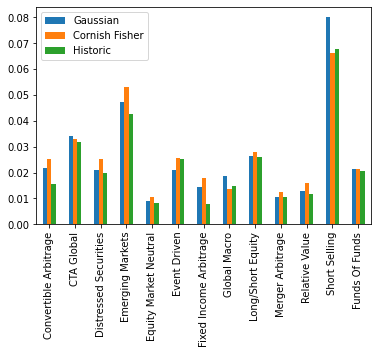

In [64]:
comparison.plot.bar()

### CVaR

In [70]:
def cvar_historic(rets, level=5):
    if isinstance(rets, pd.DataFrame):
        return rets.aggregate(cvar_historic, level=level)
    elif isinstance(rets, pd.Series):
        is_beyond = rets <= -var_historic(rets, level=level) # returns that are less than historic var
        return -rets[is_beyond].mean()    # - because var already reference a loss
    else:
        raise TypeError("Expected DataFrame or Series")

In [71]:
cvar_historic(hfi)

Convertible Arbitrage     0.036550
CTA Global                0.041264
Distressed Securities     0.036429
Emerging Markets          0.072364
Equity Market Neutral     0.016879
Event Driven              0.038336
Fixed Income Arbitrage    0.028257
Global Macro              0.020629
Long/Short Equity         0.041943
Merger Arbitrage          0.019143
Relative Value            0.024650
Short Selling             0.096821
Funds Of Funds            0.033207
dtype: float64